# Introduction

As we have considered in the experiment <a href='exp-HistogramMatching.ipynb'>`exp-HistogramMatching`</a>, the default feature detection is biased.

We know the relative position of image pieces and we can use this information to improve the performance of key detection and matching. In this experiment, we test how to use rough location in key detection.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [29]:
import os
import cv2 as cv
import numpy as np
import math
import matplotlib.pyplot as plt
import copy

from libpano import ImageCropper
from libpano import Config
from libpano import Stitcher
from libpano import FocalCalculator
from libpano import MetaData
from libpano import Preprocess

In [3]:
image_id = 'recent-04'
folder = '../images/' + image_id

meta = MetaData.MetaData(folder)
df = meta.grid_data

# Other than White Wall

"White wall" problem, in which there is not enough key features in the frame, is one of the main problem in key detection and matching.

But except the `White Wall`, there are other problems in key detection and matching. In below, I will show the problem, which I named `Biased Keys`.

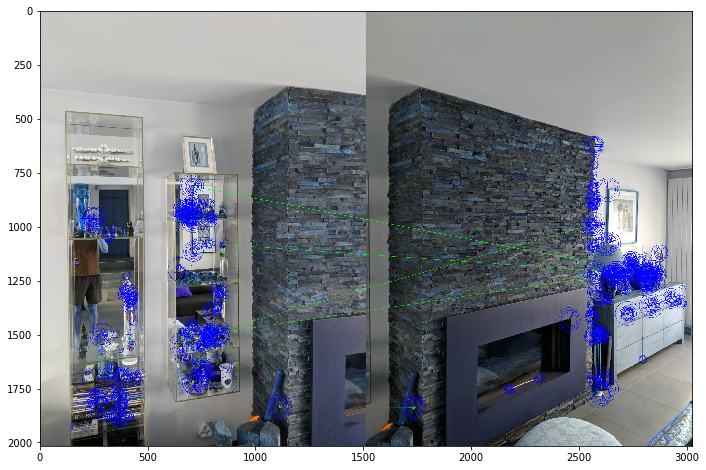

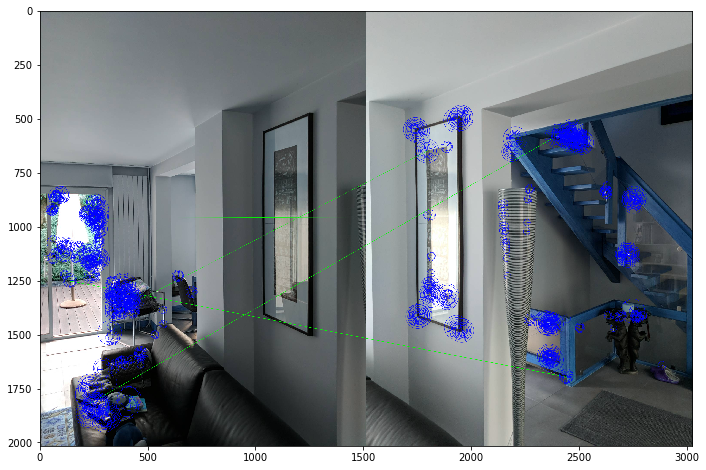

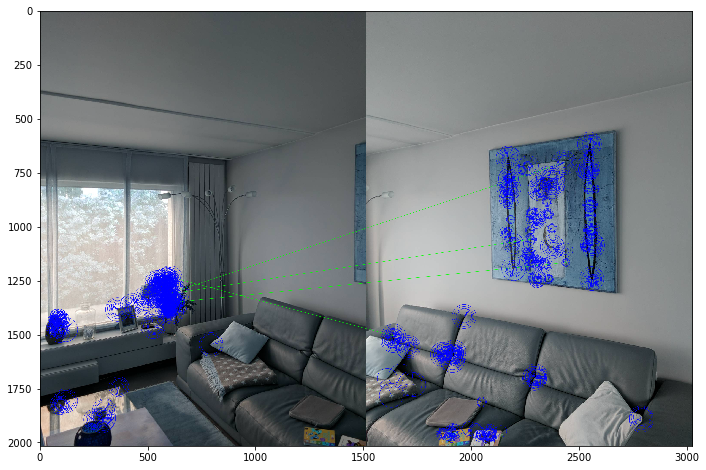

In [7]:
row = 2
uris = df[df.row == row].uri.values.tolist()
pitches = df[df.row == row].pitch.values.tolist()
yaws = df[df.row == row].yaw.values.tolist()
roll = df[df.row == row].roll.values.tolist()

image_names = []
images = []
features = []
finder = cv.ORB_create()
for uri in uris:
    img_name = os.path.join(folder, uri)
    image_names.append(img_name)

    img = cv.imread(img_name)
    images.append(img)

    feature = cv.detail.computeImageFeatures2(finder, img) # cv.cvtColor(img, cv.COLOR_BGR2GRAY))
    features.append(feature)
    
matcher = cv.detail.BestOf2NearestMatcher_create(False, 0.3)
matches = matcher.apply2(features)

bad_matches = []

for idx, match_info in enumerate(matches):
    src_idx = match_info.src_img_idx
    dst_idx = match_info.dst_img_idx

    if src_idx + 1 != dst_idx:
        continue
        
    matches_list = match_info.getMatches()
    matches_mask = match_info.getInliers().ravel().tolist()
    draw_params = dict(matchesMask=matches_mask,
                       singlePointColor=None,
                       matchColor=(0, 255, 0),
                       flags=2)
    res = cv.drawMatches(images[src_idx], 
                         features[src_idx].getKeypoints(),
                         images[dst_idx], 
                         features[dst_idx].getKeypoints(),
                         matches_list, None, **draw_params)
    # draw key points
    res = cv.drawKeypoints(res, features[src_idx].getKeypoints(), outImage=None, color=(0, 0, 255), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    right_keypoints = features[dst_idx].getKeypoints()
    width = images[src_idx].shape[1]
    for kp in right_keypoints:
        kp.pt = (kp.pt[0] + width, kp.pt[1])
    res = cv.drawKeypoints(res, right_keypoints, outImage=None, color=(0, 0, 255), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    
    if np.sum(matches_mask) < 10:
        plt.figure(figsize=(12, 8))
        plt.imshow(res)
        plt.show()


##### Those three bad matches due to the left-biased key points.

# Unbiased Feature Detection

In [12]:
row = 2
uris = df[df.row == row].uri.values.tolist()
pitches = df[df.row == row].pitch.values.tolist()
yaws = df[df.row == row].yaw.values.tolist()
roll = df[df.row == row].roll.values.tolist()



['img-r1-192.jpg', 'img-r1-217.jpg']

In [124]:
def unbiased_match(uris):
    image_names = []
    images = []

    kps = []
    descs = []

    finder = cv.ORB_create()

    for idx, uri in enumerate(uris):
        img_name = os.path.join(folder, uri)
        image_names.append(img_name)

        img = cv.imread(img_name)
        images.append(img)

        x1 = int(img.shape[1] * 0.4)  # 40% point
        x2 = int(img.shape[1] * 0.6)  # 60% point

        img_temp = copy.deepcopy(img)

        if idx % 2 == 0:
            img_temp[:, :x2, :] = 0
        else:
            img_temp[:, x1:, :] = 0
        
        feature = cv.detail.computeImageFeatures2(finder, img_temp)
        kps.append(feature.getKeypoints())
        descs.append(feature.descriptors.get())

    matcher = cv.BFMatcher()
    raw_matches = matcher.knnMatch(descs[0], descs[1], k=2)
    good_points = []
    good_matches=[]
    
    threshold = 0.2
    
    while True:
        good_points = []
        good_matches=[]
        for m1, m2 in raw_matches:
            if m1.distance < threshold * m2.distance:
                good_points.append((m1.trainIdx, m1.queryIdx))
                good_matches.append([m1])
        
        if len(good_matches) >= 7:
            break
            
        threshold += 0.05

    print(threshold)
    
    img3 = cv.drawMatchesKnn(images[0], kps[0], images[1], kps[1], good_matches, None, flags=4)        

    plt.figure(figsize=(30,15))
    plt.imshow(img3)
    plt.show()    

0.49999999999999994


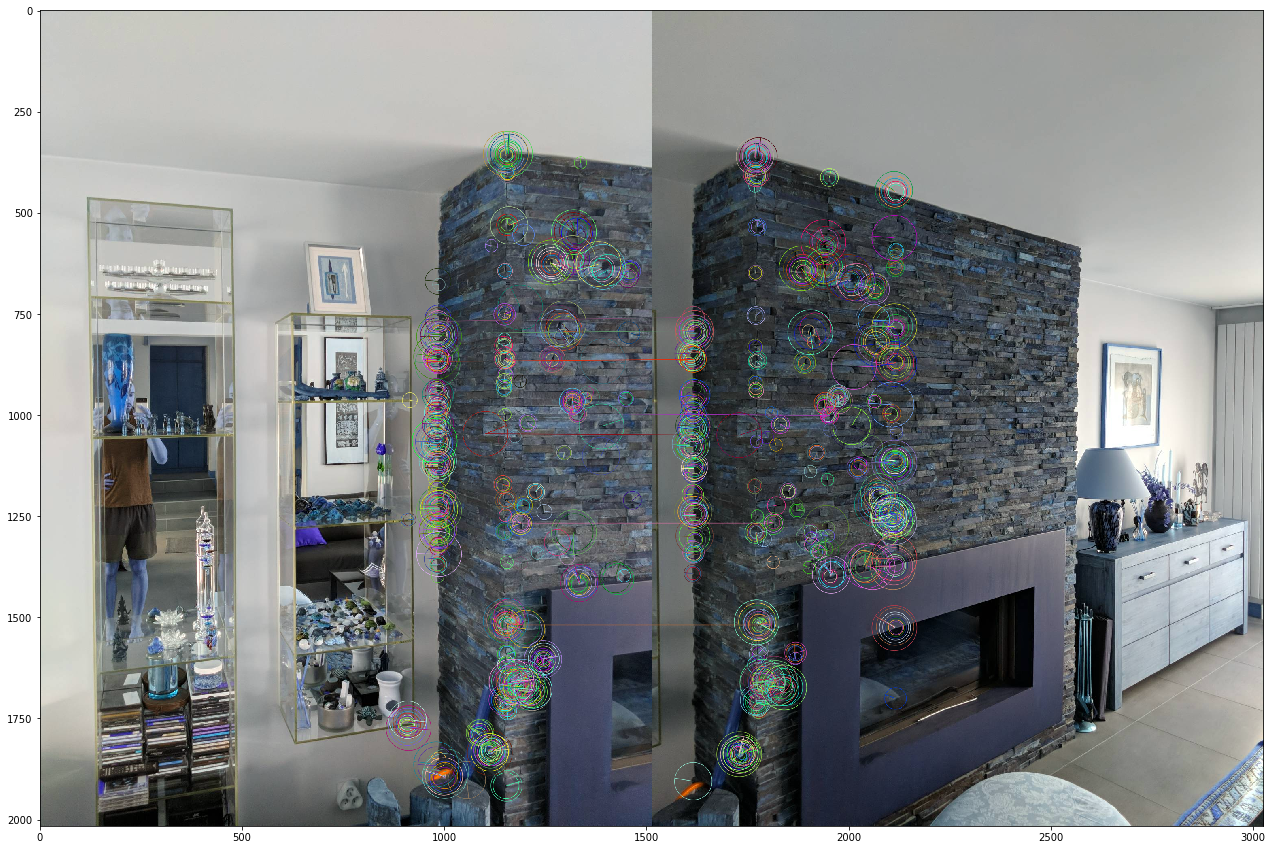

In [125]:
unbiased_match(df[(df.row == row) & ((df.col == 1) | (df.col == 2))].uri.values.tolist())

0.7000000000000001


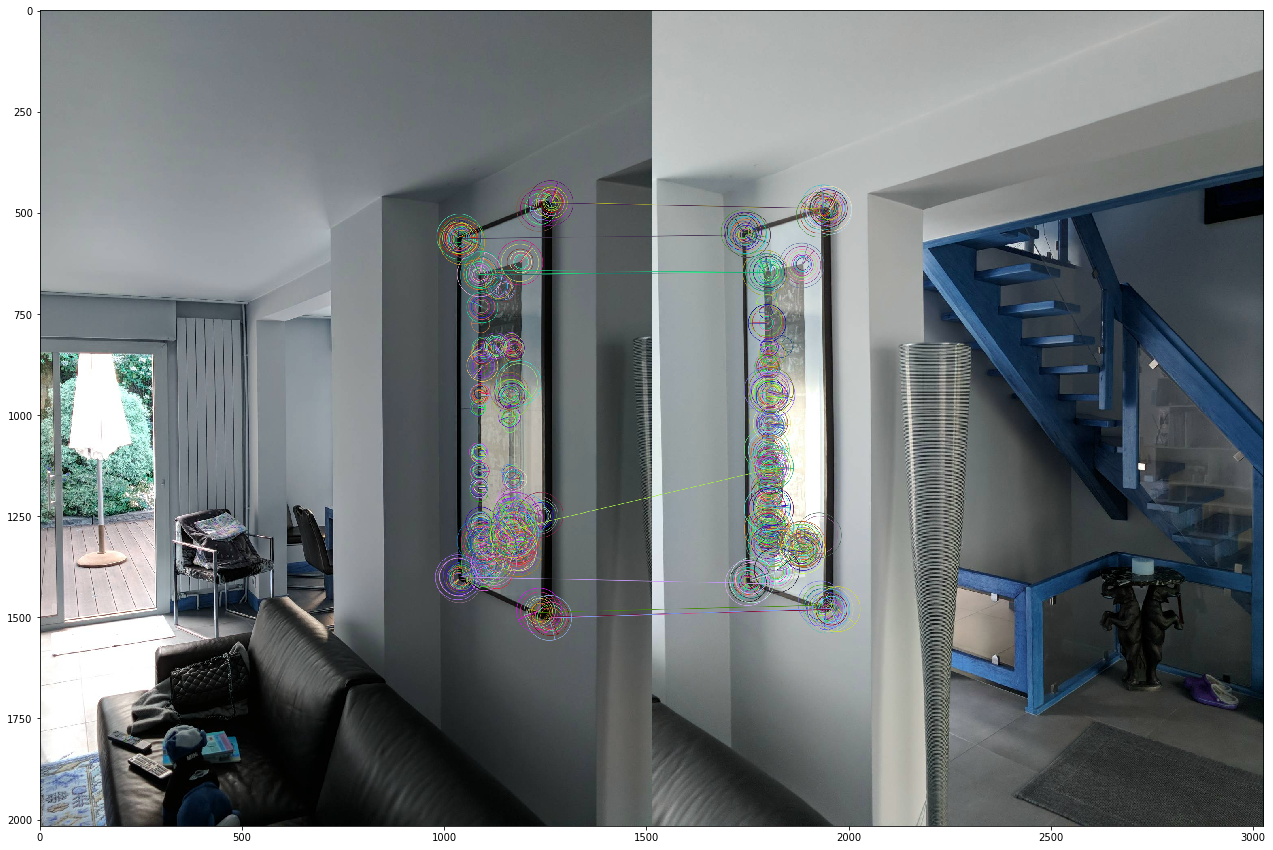

In [126]:
unbiased_match(df[(df.row == row) & ((df.col == 5) | (df.col == 6))].uri.values.tolist())

0.5499999999999999


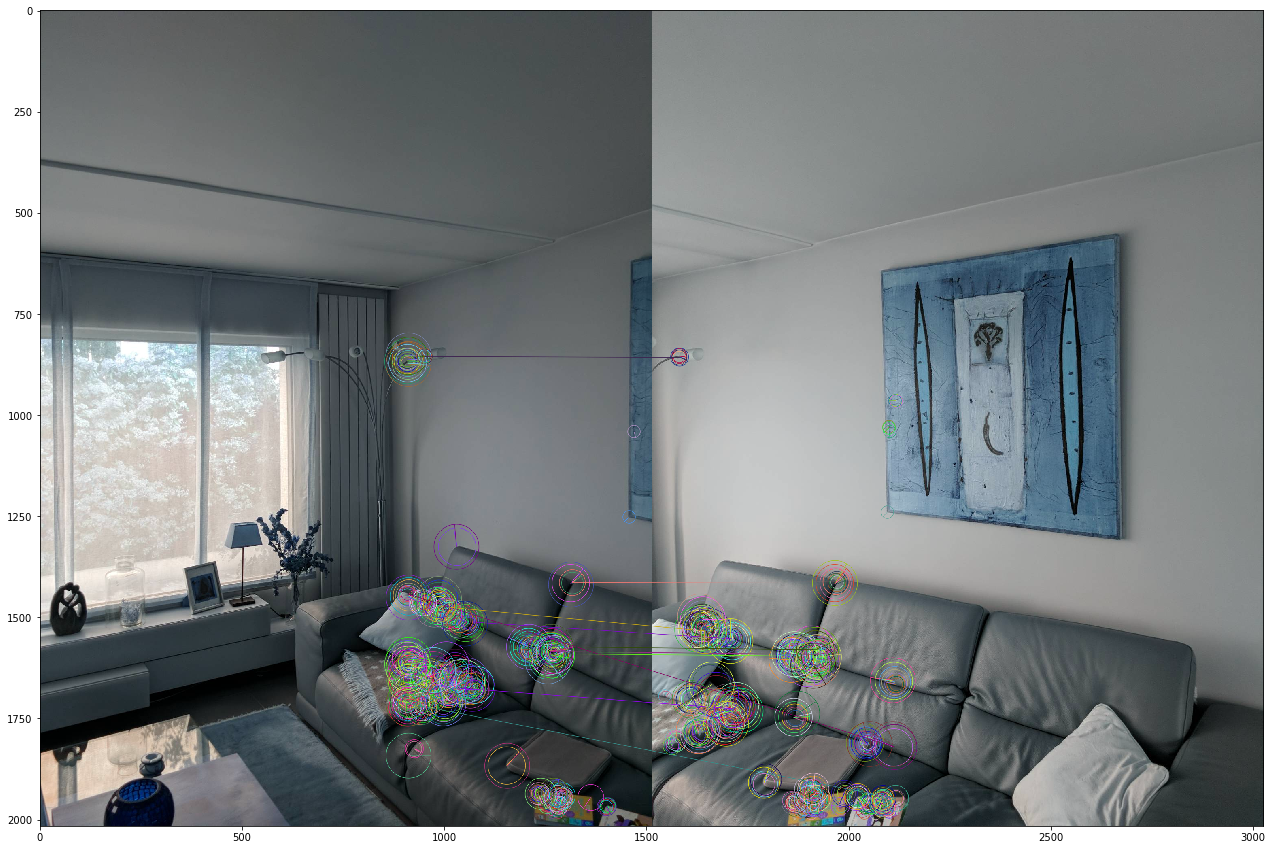

In [127]:
unbiased_match(df[(df.row == row) & ((df.col == 13) | (df.col == 14))].uri.values.tolist())

# Order of stitching
The main area of panorama contains the three middle rows. So we decided to stitch image pieces in the following order:

  10 <---------------------------   |    -----------------------------> 9 
  
   6  <-----------------------------   |    -----------------------------> 5
   
   2  <------------------------ CENTER ----------------------> 1
   
   4  <-----------------------------   |    -----------------------------> 3
   
   8  <-----------------------------   |    -----------------------------> 7


row = 2
uris = df[df.row == row].uri.values.tolist()
pitches = df[df.row == row].pitch.values.tolist()
yaws = df[df.row == row].yaw.values.tolist()
roll = df[df.row == row].roll.values.tolist()

# Step 1

In [4]:
row = df.row.nunique() // 2
col = df.col.nunique() // 2
print(row, col)

2 7
